# Parameter estimation demo: customizing runs

Parameter estimation (PE) forms an integral part of the `pygwb` package and is implemented in the `pe` module (for details, see [here](api/pygwb.pe.html)). Some aspects of PE were already covered in the dedicated tutorial [here](pe.html), where the `pygwb_pe` script was explained in more details. In this notebook, we cover how to run PE from a notebook, without relying on the `pygwb_pe`. This approach offers an additional level of flexibility, and allows the user to customize PE runs to their own needs. 

<div class="alert alert-block alert-info">
<b>Tip:</b> In this tutorial, we produce examples using the <tt>multiprocessing</tt> module, included by default in <tt>python>2.6</tt>. We reccommend running <tt>multiprocessing</tt> in <tt>jupyter lab</tt>, as there are known bugs when running <tt>multiprocessing</tt> in <tt>jupyter notebook</tt>. The present tutorial has been tried successfully with <tt>notebook v7.0.6</tt>. When in doubt, we suggest removing calls to <tt>multiprocessing</tt> by turning off the <tt>npool</tt> option when running the <tt>bilby</tt> sampler.
</div>

We start by importing some packages needed for the execution of the demo:

In [1]:
import numpy as np
import bilby
from scipy.io import loadmat
from pygwb.pe import *
from pygwb.baseline import Baseline
import bilby.gw.detector as bilbydet

*Note: make sure to run this notebook within an environment that has all the above packages installed.*

## Importing data and creating baseline

For this demo, we will run parameter estimation (PE) on the results of the LVK O3 run. For convenience, these results have been saved to file, which we now read in. Each file corresponds to one baseline, i.e., LIGO Hanford-Livingston (HL), LIGO Hanford-Virgo (HV), and LIGO Livingston-Virgo (LV), containing the point estimate spectrum $Y(f)$ and sigma spectrum $\sigma(f)$.

In [2]:
frequencies, Y_HL, sigma_HL = np.loadtxt('C_O3_HL.dat', unpack=True, usecols=(0,1,2))
Y_HV, sigma_HV = np.loadtxt('C_O3_HV.dat', unpack=True, usecols=(1,2))
Y_LV, sigma_LV = np.loadtxt('C_O3_LV.dat', unpack=True, usecols=(1,2))

Current detector sensitivity limits the frequency range our search can probe. Hence, for PE in this demo, we limit ourselves to frequencies below 256 Hz. This is done by applying a cut in the cell below.

In [3]:
idx=np.argmin(np.abs(frequencies-256))
frequencies = frequencies[:idx]

sigma_HL = sigma_HL[:idx]
Y_HL = Y_HL[:idx]
sigma_HV = sigma_HV[:idx]
Y_HV = Y_HV[:idx]
sigma_LV = sigma_LV[:idx]
Y_LV = Y_LV[:idx]

It can happen that $\sigma(f)$ contains infinities. To remedy this, we check these arrays for infinities and mask these entries out in the point estimate arrays, the sigma arrays, and the frequency array. This is repeated for each of the baselines.

In [4]:
inf_array=np.isinf(sigma_HL)
not_inf_array = ~ inf_array
sigma_HL = sigma_HL[not_inf_array]
Y_HL=Y_HL[not_inf_array]
sigma_HV = sigma_HV[not_inf_array]
Y_HV=Y_HV[not_inf_array]
sigma_LV = sigma_LV[not_inf_array]
Y_LV=Y_LV[not_inf_array]
frequencies=frequencies[not_inf_array]

inf_array=np.isinf(sigma_HV)
not_inf_array = ~ inf_array
sigma_HL = sigma_HL[not_inf_array]
Y_HL=Y_HL[not_inf_array]
sigma_HV = sigma_HV[not_inf_array]
Y_HV=Y_HV[not_inf_array]
sigma_LV = sigma_LV[not_inf_array]
Y_LV=Y_LV[not_inf_array]
frequencies=frequencies[not_inf_array]

inf_array=np.isinf(sigma_LV)
not_inf_array = ~ inf_array
sigma_HL = sigma_HL[not_inf_array]
Y_HL=Y_HL[not_inf_array]
sigma_HV = sigma_HV[not_inf_array]
Y_HV=Y_HV[not_inf_array]
sigma_LV = sigma_LV[not_inf_array]
Y_LV=Y_LV[not_inf_array]
frequencies=frequencies[not_inf_array]

The `pe` module relies on the `baseline` object as a container for the point estimate spectrum and sigma spectrum. We therefore instantiate the three baselines, i.e., HL, LV, HV, by first initializing the three detectors.

In [5]:
H1 = bilbydet.get_empty_interferometer('H1')
L1 = bilbydet.get_empty_interferometer('L1')
V1 = bilbydet.get_empty_interferometer('V1')

With these at hand, we now create the three baselines (more information about the baseline can be found [here](api/pygwb.baseline.html)).

In [6]:
HL = Baseline('H1L1', H1, L1)
HV = Baseline('H1V1', H1, V1)
LV = Baseline('L1V1', L1, V1)

/home/kevin.turbang/.conda/envs/pygwb_fixes/lib/python3.9/site-packages/pygwb/baseline.py:594: UserWarning: Neither baseline nor interferometer sampling_frequency is set.
  warnings.warn(
/home/kevin.turbang/.conda/envs/pygwb_fixes/lib/python3.9/site-packages/pygwb/baseline.py:342: UserWarning: Neither baseline nor interferometer duration is set.
  warnings.warn("Neither baseline nor interferometer duration is set.")


Note that executing the cell above returns a warning about the duration and the sampling frequency of the baseline not being set. This does not pose a problem for the `pe` module, as the `baseline` objects are solely used as containers for the spectra. This warning can therefore be ignored in this case.

The above `baseline` are still empty and do not contain the spectra needed for PE. We now set the baseline frequencies, point estimate spectrum and sigma spectrum, which are the spectra that were read in from file at the beginning of this notebook.

In [8]:
HL.frequencies = frequencies
HV.frequencies = frequencies
LV.frequencies = frequencies

HL.point_estimate_spectrum = Y_HL
HL.sigma_spectrum = sigma_HL

HV.point_estimate_spectrum = Y_HV
HV.sigma_spectrum = sigma_HV

LV.point_estimate_spectrum = Y_LV
LV.sigma_spectrum = sigma_LV

/home/kevin.turbang/.conda/envs/pygwb_maintenance/lib/python3.9/site-packages/pygwb/baseline.py:497: UserWarning: Neither baseline nor interferometer sampling_frequency is set.
  warnings.warn(
/home/kevin.turbang/.conda/envs/pygwb_maintenance/lib/python3.9/site-packages/pygwb/baseline.py:263: UserWarning: Neither baseline nor interferometer duration is set.
  warnings.warn("Neither baseline nor interferometer duration is set.")


For completeness, we also set the overlap reduction function polarisation to tensor polarization:

In [8]:
HL.orf_polarization = "tensor"
HV.orf_polarization = "tensor"
LV.orf_polarization = "tensor"

When using real detector data, a calibration uncertainty (referred to as calibration epsilon) can be taken into account for each of the baselines. This is also set as an attribute of the baseline:

In [9]:
HL.calibration_epsilon = 0.148
HV.calibration_epsilon = 0.123
LV.calibration_epsilon = 0.108

Depending on the value of the calibration epsilon, i.e., if it is zero or not, the `pe` module will execute a slightly different version of the likelihood to account for this extra uncertainty. Note that if the calibration epsilon is not specified at the level of the `baseline`, it defaults to zero. For more information and the source code where this is handled, see [here](api/pygwb.pe.GWBModel.html#pygwb.pe.GWBModel.log_likelihood_IJ).

## Run parameter estimation for a power-law model

With the different baselines set and containing the spectra needed to run PE, we are ready to call the `pe` module. One needs to decide which model to run PE on. Several models are provided within the `pe` module. We run PE on the power-law model, illustrating how the `pe` module can be used to perform PE. We will go into details for the first model, and refer the user to the API [documentation](api/pygwb.pe.html) of each model to run PE for the other models of the module.

As a reminder, the likelihood takes the form: 
$$
p(\hat{C}^{IJ}(f_k) | \mathbf{\Theta}) \propto\exp\left[  -\frac{1}{2} \sum_{IJ}^N \sum_k \left(\frac{\hat{C}^{IJ}(f_k) - \Omega_{\rm M}(f_k|\mathbf{\Theta})}{\sigma_{IJ}(f_k)}\right)^2  \right],
$$
where $\Omega_{\rm M}(f_k|\mathbf{\Theta})$ is the model being fit to point estimate spectra $\hat{C}^{IJ}(f_k)$ with variance $\sigma^2_{IJ}(f_k)$, running over baselines $IJ$, and $\mathbf{\Theta}$ are the model's parameters.

*Disclaimer: as we are running this demo on LVK O3 data, we do not expect to recover anything from PE, since no gravitational-wave background was detected. However, one can repeat this demo on spectra obtained from simulated data sets that contain a signal, to see how the recovery with PE looks like.*

Consider a simple power-law. As a reminder, the model is given by 
$$
\Omega(f) = \Omega_{\text{ref}} \left(\frac{f}{f_{\text{ref}}}\right)^{\alpha}.
$$
More information on the implementation of this model can be found [here](api/pygwb.pe.PowerLawModel.html#pygwb.pe.PowerLawModel).

The `pe` module expects some `kwargs` for this model, including the `baseline` objects to include in the PE run (note that these contain the spectra, as specified above in this demo), as well as the model name and a reference frequency (which defaults to 25 Hz if not specified).

In [10]:
kwargs_pl = {"baselines":[HL,HV,LV], "model_name":'PL', "fref":25}

Note in the above expression one could decide to only run for one of the baselines, by passing only e.g., `"baselines":[HL]`.

The model used for PE can then be instantiated, by passing it the necessary `kwargs`:

In [12]:
model_pl = PowerLawModel(**kwargs_pl)

For each of the model parameters, a prior needs to be specified. For this, we rely on the `bilby` package (remember that the whole `pe` module is based on `bilby`). For more information about the possible prior choices, we refer the reader to [this page](https://lscsoft.docs.ligo.org/bilby/prior.html).

In [13]:
priors_pl = {'omega_ref': bilby.core.prior.LogUniform(1e-13, 1e-5, '$\\Omega_{\\rm ref}$'),
                        'alpha': bilby.core.prior.Gaussian(0, 3.5, '$\\alpha$')}

One can now run PE by calling the `bilby` sampler with our model as a likelihood.

In [ ]:
hlv_pl=bilby.run_sampler(likelihood=model_pl,priors=priors_pl,sampler='dynesty', npoints=1000, walks=10, npool=10, outdir='./pe/',label= 'hlv_pl', resume=False)

To plot the results of the PE run, we rely on the `plot_corner()` method of `bilby`. More information on the `bilby` package can be found [here](https://lscsoft.docs.ligo.org/bilby/api/bilby.core.result.Result.html#bilby.core.result.Result). This shows the 1D and 2D posteriors on the parameters of our model.

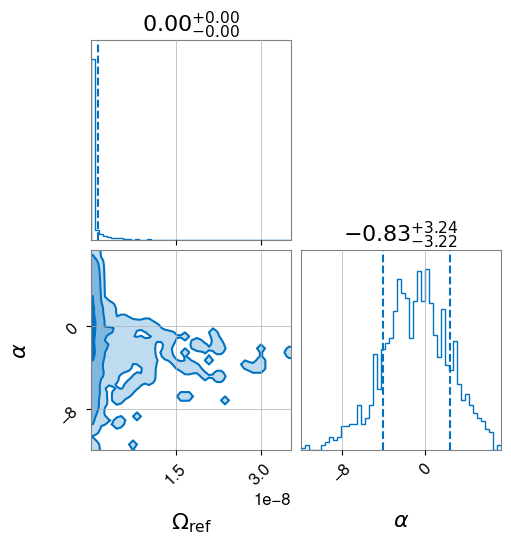

In [15]:
hlv_pl.plot_corner()

As mentioned before, we do not recover a specific parameter value, as no gravitational-wave background was detected during the LIGO-Virgo third observing run O3.

Note that the steps that were carried out so far in the notebook, is exactly what the `pygwb_pe` script does. More information on the script can be found [here](pe.html).

We refrain from providing a demo for each of the models. From the API pages, it should be clear what the parameters of each model are. Note that a prior should be passed for each of these parameters. For example, for the broken power-law model (see [here](api/pygwb.pe.BrokenPowerLawModel.html)), the parameters of the model are different, resulting in a different prior as well:

In [ ]:
kwargs_bpl = {"baselines": [HL, HV, LV], "model_name":'BPL'}
model_bpl = BrokenPowerLawModel(**kwargs_bpl)
priors_bpl = {'omega_ref': bilby.core.prior.LogUniform(1e-13, 1e-5, '$\\Omega_{\\rm ref}$'),
            'fbreak': bilby.core.prior.Uniform(1, 100,'$f_{\\rm break}$'),
            'alpha_1': bilby.core.prior.Gaussian(0, 3.5, '$\\alpha_1$'),
            'alpha_2': bilby.core.prior.Gaussian(0, 3.5, '$\\alpha_2$')}

## Non-GR polarizations: tensor-vector-scalar polarization model

To illustrate some of the specifics of the `pe` module, we show how the module allows for polarizations that go beyond the tensor polarization of General Relativity (GR). The model we now consider allows for a linear combination  of combinations of different polarizations.  As a reminder, the model is given by 
$$
\Omega(f) = \Omega _T + \Omega _V + \Omega _S,
$$
where
$$
\Omega _T = \Omega _{{\text{ref}},T} \left( \frac{f}{f_{\text{ref}}}\right)^{\alpha _T},
$$
$$
\Omega _V = (\gamma _V/\gamma_T)~\Omega _{{\text{ref}},V} \left( \frac{f}{f_{\text{ref}}}\right)^{\alpha _V},
$$
and
$$
\Omega _S = (\gamma_S/\gamma_T)~\Omega _{{\text{ref}},S} \left( \frac{f}{f_{\text{ref}}}\right)^{\alpha _S}.
$$
More information on the implementation of this model can be found [here](api/pygwb.pe.TVSPowerLawModel.html).

Note that the effect of different polarizations would be apparent in the overlap reduction function. Indeed, as was illustrated in [this](test_orfs.html) demo, the overlap reduction function differs, depending on the assumed polarization. More information about the computation of the overlap reduction function for different polarizations can be found on the API page of the `orfs` module [here](api/pygwb.orfs.html).

One can specify for which polarizations to run, by using the `"polarizations"` kwarg, as shown below:

In [ ]:
kwargs_pl_sv={"baselines":[HL, HV, LV], "model_name":'PL_SV', "fref":25, "polarizations":['scalar', 'vector']}
model_pl_sv = TVSPowerLawModel(**kwargs_pl_sv)
priors_pl_sv = {'omega_ref_scalar': bilby.core.prior.LogUniform(1e-13, 1e-5, '$\\Omega_{\\rm ref,s}$'),
                      'alpha_scalar': bilby.core.prior.Gaussian(0, 3.5, '$\\alpha_s$'),
          'omega_ref_vector': bilby.core.prior.LogUniform(1e-13, 1e-5, '$\\Omega_{\\rm ref,v}$'),
                      'alpha_vector': bilby.core.prior.Gaussian(0, 3.5, '$\\alpha_v$')}
hlv_pl_sv=bilby.run_sampler(likelihood=model_pl_sv,priors=priors_pl_sv,sampler='dynesty', npoints=1000, walks=10,npool=10,outdir='./pe/',label= 'hlv_pl_sv', resume=False)

Note that as mentioned before, priors should be changed to reflect the parameters of the model being considered.

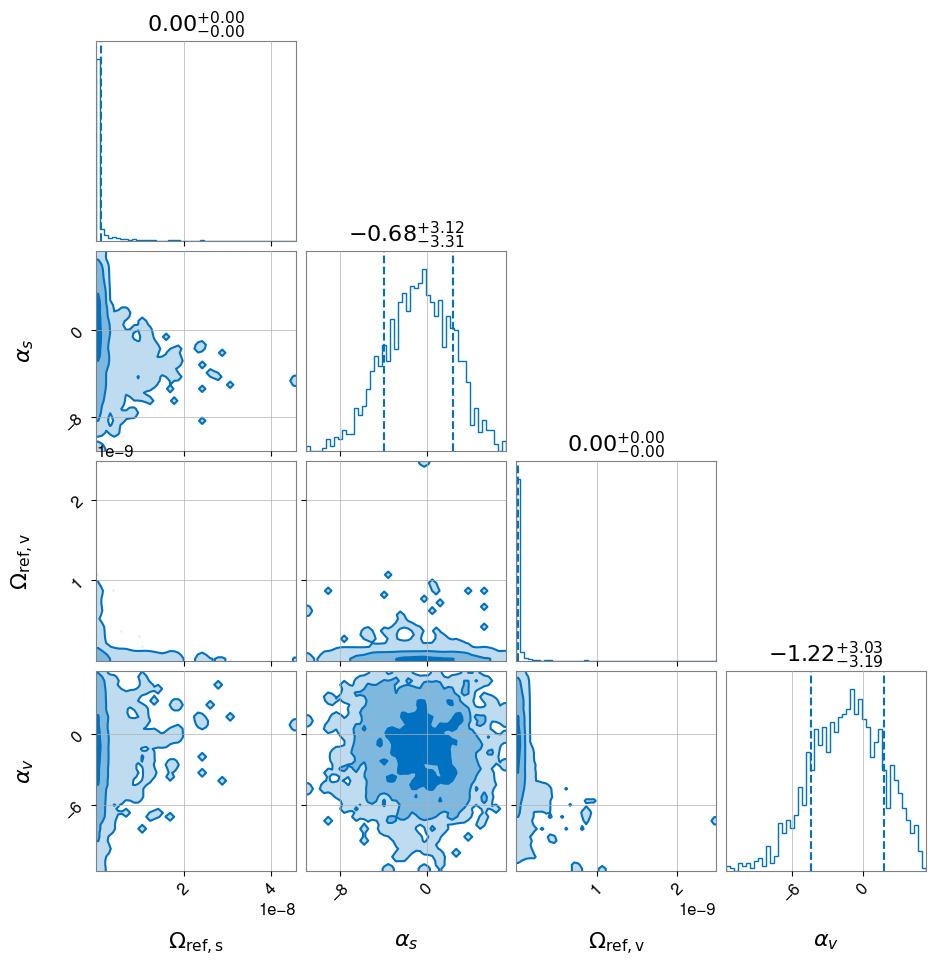

In [25]:
hlv_pl_sv.plot_corner()

## Combining models

The `pe` module also offers the possibility of combining models and performing inference jointly. Concrete examples of why this could be useful include: 

- A cosmological gravitational-wave background in the presence of an astrophysical background
- Correlated magnetic noise in the presence of a gravitational-wave background

The option to perform inference simultaneoulsy on different models, allows to take into account *all* contributions to the gravitaional-wave background estimator as computed in `pygwb`.

Understanding correlated magnetic noise, also called Schumann resonances, forms an important part of a stochastic gravitational-wave background analysis. This model allows to search for such Schumann resonances with a PE run.  As a reminder, the model is given by 
$$
\Omega(f) = \sum_{ij} \kappa_i \kappa_j \left(\frac{f}{f_{\text{ref}}}\right)^{-\beta_i-\beta_j} M_{ij}(f) \times 10^{-46}.
$$
More information on the implementation of this model can be found [here](api/pygwb.pe.SchumannModel.html).

However, for this model, we need additional data, namely from magnetometers. We repeat the steps from the beginning of the demo, where we load in the data. We again apply a frequency cut, due to our sensitivity limitations at higher frequencies, and set the baselines with the various spectra. We will not go through all the details, and refer the reader to the beginning of this notebook for additional information.

In [9]:
frequencies, Y_HL, sigma_HL = np.loadtxt('C_O3_HL.dat', unpack=True, usecols=(0,1,2))
Y_HV, sigma_HV = np.loadtxt('C_O3_HV.dat', unpack=True, usecols=(1,2))
Y_LV, sigma_LV = np.loadtxt('C_O3_LV.dat', unpack=True, usecols=(1,2))

mag_data = loadmat('magnetic_data_product_for_pe.mat')  
M_HL=(mag_data['hl']['ptEst_mag'][0][0].real)[0]
M_HV=(mag_data['hv']['ptEst_mag'][0][0].real)[0]
M_LV=(mag_data['lv']['ptEst_mag'][0][0].real)[0]

idx=np.argmin(np.abs(frequencies-99))
frequencies = frequencies[:idx]
sigma_HL = sigma_HL[:idx]
Y_HL = Y_HL[:idx]
M_HL = M_HL[:idx]
sigma_HV = sigma_HV[:idx]
Y_HV = Y_HV[:idx]
M_HV = M_HV[:idx]
sigma_LV = sigma_LV[:idx]
Y_LV = Y_LV[:idx]
M_LV = M_LV[:idx]

#remove infinities from sigma measurements
inf_array=np.isinf(sigma_HL)
not_inf_array = ~ inf_array
sigma_HL = sigma_HL[not_inf_array]
Y_HL=Y_HL[not_inf_array]
M_HL=M_HL[not_inf_array]
sigma_HV = sigma_HV[not_inf_array]
Y_HV=Y_HV[not_inf_array]
M_HV=M_HV[not_inf_array]
sigma_LV = sigma_LV[not_inf_array]
Y_LV=Y_LV[not_inf_array]
M_LV=M_LV[not_inf_array]
frequencies=frequencies[not_inf_array]

inf_array=np.isinf(sigma_HV)
not_inf_array = ~ inf_array
sigma_HL = sigma_HL[not_inf_array]
Y_HL=Y_HL[not_inf_array]
M_HL=M_HL[not_inf_array]
sigma_HV = sigma_HV[not_inf_array]
Y_HV=Y_HV[not_inf_array]
M_HV=M_HV[not_inf_array]
sigma_LV = sigma_LV[not_inf_array]
Y_LV=Y_LV[not_inf_array]
M_LV=M_LV[not_inf_array]
frequencies=frequencies[not_inf_array]

inf_array=np.isinf(sigma_LV)
not_inf_array = ~ inf_array
sigma_HL = sigma_HL[not_inf_array]
Y_HL=Y_HL[not_inf_array]
M_HL=M_HL[not_inf_array]
sigma_HV = sigma_HV[not_inf_array]
Y_HV=Y_HV[not_inf_array]
M_HV=M_HV[not_inf_array]
sigma_LV = sigma_LV[not_inf_array]
Y_LV=Y_LV[not_inf_array]
M_LV=M_LV[not_inf_array]
frequencies=frequencies[not_inf_array]

#remove nans from mag data
nan_array = np.isnan(M_HL)
not_nan_array = ~ nan_array
sigma_HL = sigma_HL[not_nan_array]
Y_HL=Y_HL[not_nan_array]
M_HL=M_HL[not_nan_array]
sigma_HV = sigma_HV[not_nan_array]
Y_HV=Y_HV[not_nan_array]
M_HV=M_HV[not_nan_array]
sigma_LV = sigma_LV[not_nan_array]
Y_LV=Y_LV[not_nan_array]
M_LV=M_LV[not_nan_array]
frequencies=frequencies[not_nan_array]

nan_array = np.isnan(M_HV)
not_nan_array = ~ nan_array
sigma_HL = sigma_HL[not_nan_array]
Y_HL=Y_HL[not_nan_array]
M_HL=M_HL[not_nan_array]
sigma_HV = sigma_HV[not_nan_array]
Y_HV=Y_HV[not_nan_array]
M_HV=M_HV[not_nan_array]
sigma_LV = sigma_LV[not_nan_array]
Y_LV=Y_LV[not_nan_array]
M_LV=M_LV[not_nan_array]
frequencies=frequencies[not_nan_array]

nan_array = np.isnan(M_LV)
not_nan_array = ~ nan_array
sigma_HL = sigma_HL[not_nan_array]
Y_HL=Y_HL[not_nan_array]
M_HL=M_HL[not_nan_array]
sigma_HV = sigma_HV[not_nan_array]
Y_HV=Y_HV[not_nan_array]
M_HV=M_HV[not_nan_array]
sigma_LV = sigma_LV[not_nan_array]
Y_LV=Y_LV[not_nan_array]
M_LV=M_LV[not_nan_array]
frequencies=frequencies[not_nan_array]

H1 = bilbydet.get_empty_interferometer('H1')
L1 = bilbydet.get_empty_interferometer('L1')
V1 = bilbydet.get_empty_interferometer('V1')

HL = Baseline('HL', H1, L1)
HV = Baseline('HV', H1, V1)
LV = Baseline('LV', L1, V1)

HL.frequencies = frequencies
HV.frequencies = frequencies
LV.frequencies = frequencies

HL.M_f = M_HL
HV.M_f = M_HV
LV.M_f = M_LV

HL.point_estimate_spectrum = Y_HL
HL.sigma_spectrum = sigma_HL
HV.point_estimate_spectrum = Y_HV
HV.sigma_spectrum = sigma_HV
LV.point_estimate_spectrum = Y_LV
LV.sigma_spectrum = sigma_LV

We now run the combined power-law and Schumann resonance model below.

In [ ]:
kwargs_PL = {"baselines": [HL],"model_name": "PL","fref": 25}
PL_model = PowerLawModel(**kwargs_PL)

kwargs_Schumann = {"baselines": [HL], "model_name": "Schu"}
Schu_model = SchumannModel(**kwargs_Schumann)

kwargs_combined={"baselines":[HL], "model_name":'PL+Schu', "polarizations":['tensor'], "model1":PL_model,"model2":Schu_model}

model = CombinedModel(**kwargs_combined)

priors= {'kappa_H': bilby.core.prior.LogUniform(0.01, 10, '$\\kappa_H$'),
            'kappa_L': bilby.core.prior.LogUniform(0.01, 10, '$\\kappa_L$'),
            'kappa_V': bilby.core.prior.LogUniform(0.01, 10, '$\\kappa_V$'),
            'beta_H': bilby.core.prior.Uniform(0.0, 12.0, '$\\beta_H$'),
            'beta_L': bilby.core.prior.Uniform(1.0, 10.0, '$\\beta_L$'),
           'beta_V': bilby.core.prior.Uniform(0.0, 7.0, '$\\beta_V$'),
            'omega_ref': bilby.core.prior.LogUniform(1e-13, 1e-5, '$\\Omega_{\\rm ref}$'),
             'alpha': bilby.core.prior.Gaussian(0, 3.5, '$\\alpha$')}
hlv_gw_schu=bilby.run_sampler(likelihood=model,priors=priors,sampler='dynesty', npoints=1000, walks=10,outdir='./pe/',label= 'hlv_combined_models', resume=False)

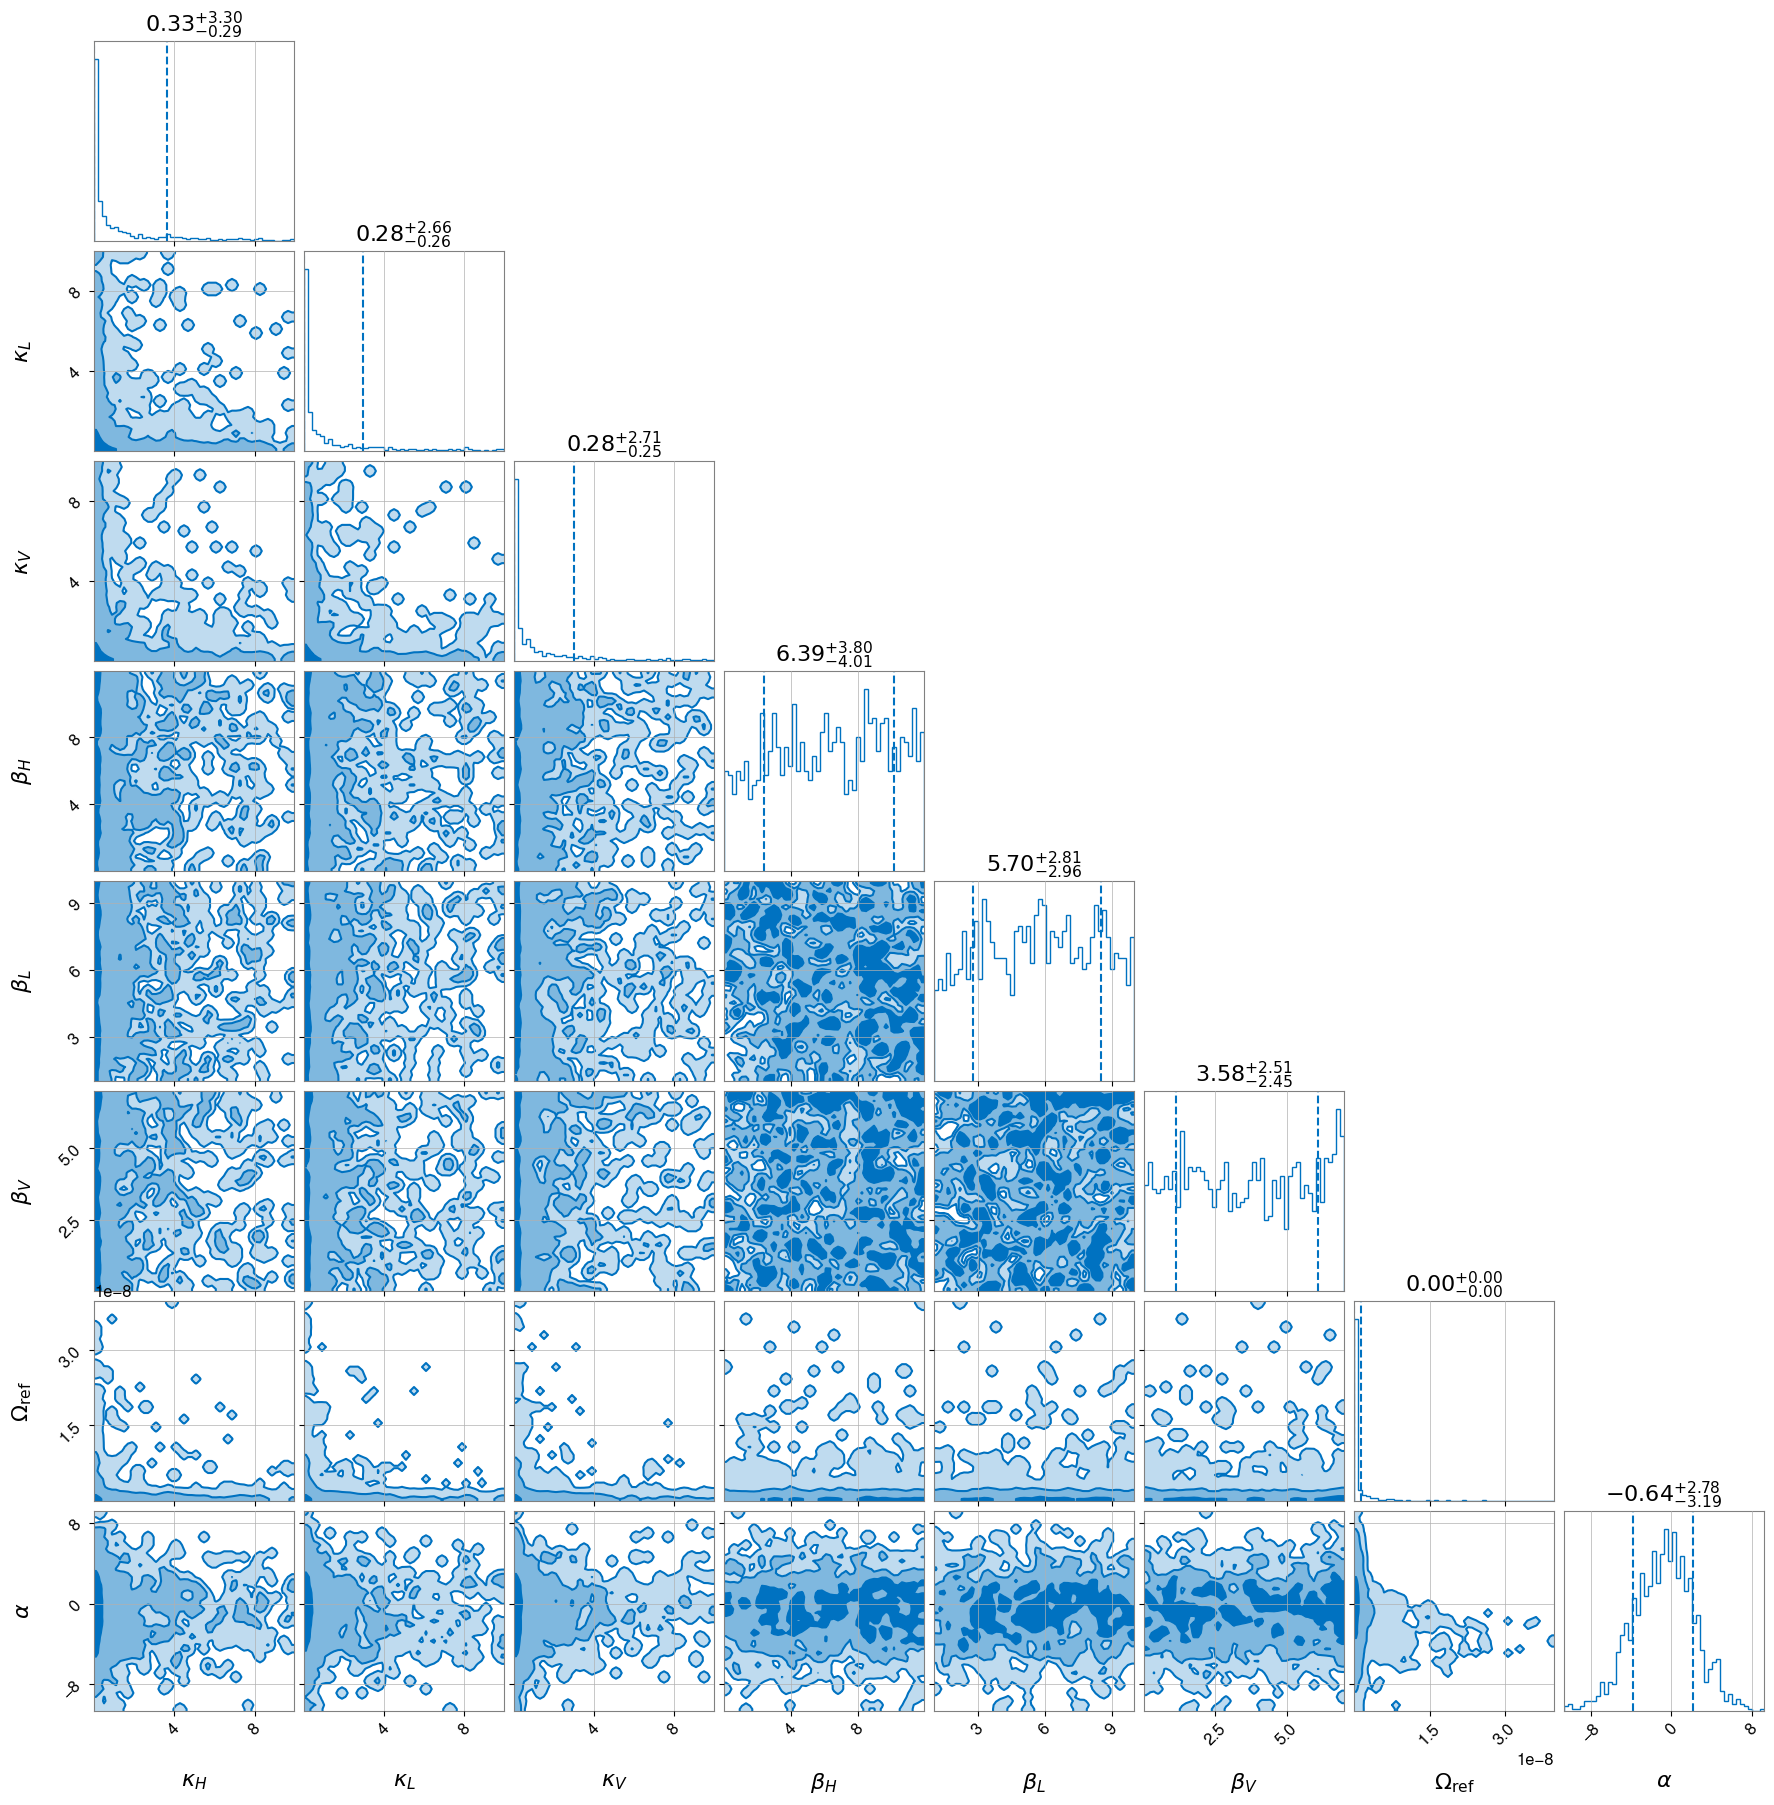

In [14]:
hlv_gw_schu.plot_corner()

**Disclaimer**

Note that the joint inference of two different models can only be performed if none of the parameter names are shared, otherwise the PE code does not know which parameter to infer of the two models. This could be remedied by changing the parameter name in one of the models in the `pe` code fo example.

In [ ]:
# # ##############################################
# # ########        Testing Geodesy        #######
# # ##############################################
#kwargs = {"baselines":[HL], "model_name":'Geodesy', "fref":25}
#model = Geodesy(**kwargs)

#priors = {'omega_ref': bilby.core.prior.LogUniform(1e-13, 1e-5, '$\\Omega_{\\rm ref}$'),
#               'alpha': bilby.core.prior.Gaussian(2./3, 3.5, '$\\alpha$'),
#               'beta': bilby.core.prior.Uniform(0, 2*np.pi, '$\\beta$'),
#               'omega_det1': bilby.core.prior.Uniform(-np.pi,np.pi, '$\\Omega_1$'),
#               'omega_det2': bilby.core.prior.Uniform(-np.pi,np.pi, '$\\Omega_2$')}

#injection_params = dict(beta = 0.4757189334754699, omega_det1 = -28535176597882725, omega_det2= -1.2848910022634024) #For HL baseline

#result=bilby.run_sampler(likelihood=model,priors=priors,sampler='dynesty', injection_parameters = injection_params, npoints=1000, walks=10, npool=10, outdir='./',label= 'hlv_geodesy', resume=False)
#result.plot_corner()